In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
import os
import time
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [11]:
import darknet
from darknet import parse_cfg
from darknet import prediction, create_model
from darknet import EmptyLayer, DetectionLayer, Darknet
from prediction import  bbox_iou, unique, write_results, load_classes, prep_image, letterbox_image

In [12]:
weight_file = '.\pretrained_weight\yolov3.weights'
yolo_configuration = '.\cfg\yolov3.cfg'
classes_file = '.\pretrained_weight\coco.names'

In [13]:
blocks = parse_cfg(yolo_configuration)
print(create_model(blocks))

({'type': 'net', 'batch': '64', 'subdivisions': '16', 'width': '608', 'height': '608', 'channels': '3', 'momentum': '0.9', 'decay': '0.0005', 'angle': '0', 'saturation': '1.5', 'exposure': '1.5', 'hue': '.1', 'learning_rate': '0.001', 'burn_in': '1000', 'max_batches': '500200', 'policy': 'steps', 'steps': '400000,450000', 'scales': '.1,.1'}, ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): Sequential(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (2): Sequential(
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [14]:
CUDA = True
batch_size = 2

print("Start Loading")
model = Darknet(yolo_configuration)
model.load_weights(weight_file)
print("Network and weight loaded")
classes = load_classes(classes_file)
print('Classes loaded')
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0
assert inp_dim > 32

if CUDA:
    model.cuda()

model.eval()

Start Loading
Network and weight loaded
Classes loaded


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [15]:
input_image = r'imgs\baseball.jpeg'    # you can choose specific image here to generate outputs
output_image = r'output'

In [16]:
try:
    image_list = [os.path.join(os.path.realpath('.'), input_image, img) for img in os.listdir(input_image)]
except NotADirectoryError:
    image_list = []
    image_list.append(os.path.join(os.path.realpath('.'), input_image))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(input_image))
    exit()

if not os.path.exists(output_image):
    os.makedirs(output_image)

load_batch = time.time()

# preparing list of loaded images
# [[image,original_image,dim[0],dim[1]]]
batches = list(map(prep_image, image_list, [inp_dim for x in range(len(image_list))]))
im_batches = [x[0] for x in batches] # list of resized images
orig_ims = [x[1] for x in batches] # list of original images
image_dim_list = [x[2] for x in batches] # dimension list
image_dim_list = torch.FloatTensor(image_dim_list).repeat(1,2) #repeating twice


if CUDA:
    image_dim_list = image_dim_list.cuda()


# converting image to batches
reminder = 0
if (len(image_dim_list) % batch_size): #if reminder is there, reminder = 1
    reminder = 1

if batch_size != 1:
    num_batches = len(image_list) // batch_size + reminder
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,len(im_batches))]))
                 for i in range(num_batches)]


i = 0
write = False

objs = {}
for batch in im_batches:
        #load the image
        start = time.time()
        if CUDA:
            batch = batch.cuda()

        with torch.no_grad():
            prediction = model(Variable(batch), CUDA)

        prediction = write_results(prediction, confidence=0.5, num_classes=80, nms_conf = 0.5)

        if type(prediction) == int:
            i += 1
            continue


        prediction[:,0] += i*batch_size

        if not write:
            output = prediction
            write = 1
        else:
            output = torch.cat((output,prediction))  # concating predictions from each batch
        i += 1

        if CUDA:
            torch.cuda.synchronize()

try:
    output
except NameError:
    print("No detections were made")
    exit()

In [17]:
image_dim_list = torch.index_select(image_dim_list, 0, output[:,0].long())
scaling_factor = torch.min(inp_dim/image_dim_list,1)[0].view(-1,1)
output[:,[1,3]] -= (inp_dim - scaling_factor*image_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*image_dim_list[:,1].view(-1,1))/2
output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, image_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, image_dim_list[i,1])



def write(x, batches, results):
    c1 = tuple(x[1:3].cpu().int().numpy())
    c2 = tuple(x[3:5].cpu().int().numpy())
    img = results[int(x[0])]
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = (0,0,255)
    cv2.rectangle(img, c1, c2,color, 2)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img


list(map(lambda x: write(x, im_batches, orig_ims), output))

det_names = pd.Series(image_list).apply(lambda x: r"{}\det_{}".format(output_image,x.split("\\")[-1]))

# see whether it successfully generate the output
print(list(map(cv2.imwrite, det_names, orig_ims)))


torch.cuda.empty_cache()

[True]


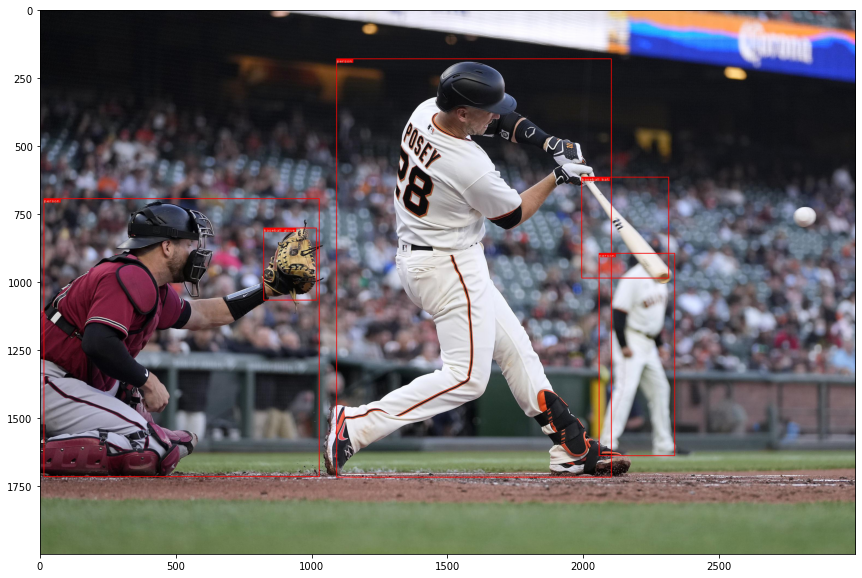

In [20]:
img = cv2.imread(r'output\det_baseball.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)

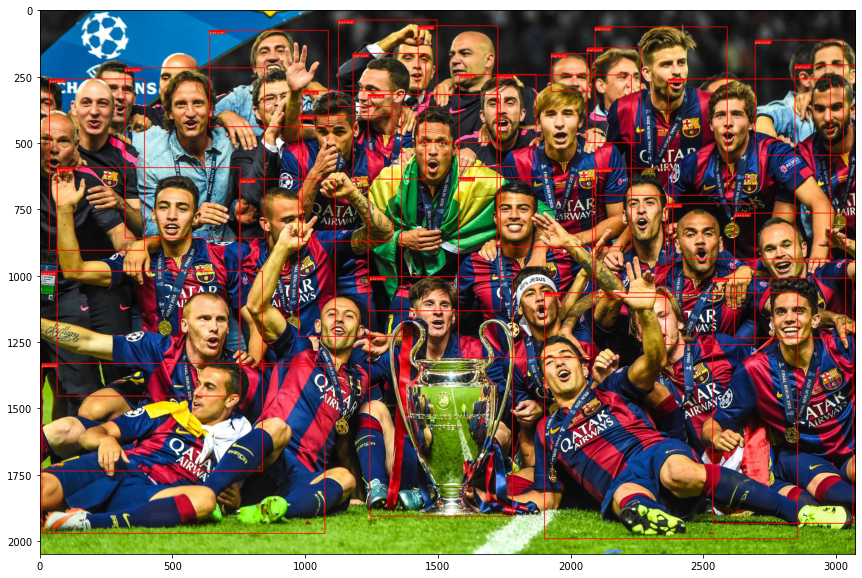

In [21]:
img = cv2.imread(r'output\det_barca.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)